In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import mixture, preprocessing, datasets

from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

import torch.utils.data as data_utils

import sys
sys.path.append("..")

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers
import utils.perceptual as perc
import model_paths

In [64]:
dim = 3072

dl.path = '../../data'
train_loader = dl.CIFAR10(train=True)

batch_size = 500
test_loader = dl.CIFAR10(train=False, batch_size=batch_size)
out_loader = dl.SVHN(train=False, batch_size=batch_size)


vgg = perc.Vgg16()
perc_metric = models.PerceptualMetric(vgg)

l2 = models.LpMetric()


X = []
for x, f in train_loader:
    X.append(x.view(-1, dim))
X = torch.cat(X, 0)

X = X[:50000] #needed to keep memory of distance matrix below 800 GB
pca = models.PCAMetric( X, p=2, min_sv_factor=1e6)


X = []
for x, f in train_loader:
    X.append(vgg(x)[:,perc_metric.indices])
X = torch.cat(X, 0)

X = X[:50000] #needed to keep memory of distance matrix below 800 GB
perc_pca = models.PCAMetric( X, p=2, min_sv_factor=1e6)
perc_pca_metric = models.PerceptualPCA(vgg, perc_pca, indices=perc_metric.indices)

#device = torch.device('cuda:4')

In [36]:
data = next(iter(test_loader))[0].view(-1,3*32*32)
data_out = next(iter(out_loader))[0].view(-1,3*32*32)
noise = torch.rand(batch_size, 3072)

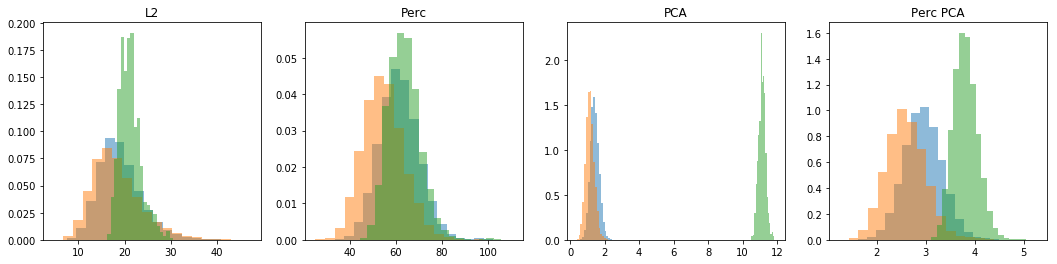

In [75]:
compare = [data, data_out, noise]
metric_list = [l2, perc_metric, pca, perc_pca_metric]
metric_names = ['L2', 'Perc', 'PCA', 'Perc PCA']

f = plt.figure(figsize=(4.5*len(metric_list), 4))
for i, metric in enumerate(metric_list):
    plt.subplot(1, len(metric_list), 1+i)
    for c in compare:
        dist = metric(data.view(batch_size, 1, 3072), c.view(1, batch_size, 3072), dim=2)
        plt.hist(dist[dist!=0.].view(-1), density=True, alpha=.5, bins=20)
        plt.title(metric_names[i])

plt.show()
f.savefig('metrics_CIFAR10.eps', format='eps', bbox_inches = 'tight', pad_inches = 0)

In [77]:
vgg(data).shape

torch.Size([500, 122880])